In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from keras.models import load_model
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
import keras.backend as K
from glob import glob
from os.path import join
import logging

Using TensorFlow backend.


In [2]:
class MinMaxScaler2D(object):
    """
    Rescale input arrays of shape (examples, y, x, variable) to range from out_min to out_max.

    """
    def __init__(self, out_min=0, out_max=1, scale_values=None):
        self.out_min = out_min
        self.out_max = out_max
        self.out_range = out_max - out_min
        self.scale_values = scale_values

    def fit(self, x, y=None):
        """
        Calculate the values for the min/max transformation.
        """
        variables = np.arange(x.shape[1])
        self.scale_values = pd.DataFrame(0, index=variables, columns=["min", "max"])
        for v in variables:
            self.scale_values.loc[v, "min"] = x[:, v].min()
            self.scale_values.loc[v, "max"] = x[:, v].max()
            self.scale_values.loc[v, "range"] = self.scale_values.loc[v, "max"] - self.scale_values.loc[v, "min"]

    def transform(self, x):
        """
        Apply the min/max scaling transformation.
        """
        if x.shape[1] != self.scale_values.index.size:
            raise ValueError("Input x does not have the correct number of variables")
        x_new = np.zeros(x.shape, dtype=x.dtype)
        for v in self.scale_values.index:
            x_new[:, v] = (x[:, v] - self.scale_values.loc[v, "min"]) \
                / (self.scale_values.loc[v, "range"])
            if self.out_min != 0 or self.out_max != 1:
                x_new[:, v] = x_new[:, v] * self.out_range + self.out_min
        return x_new

    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x)
def load_single_data_file(filename, image_variable="abi", count_variable="flash_counts", time_variable="time"):
    ds = xr.open_dataset(filename)
    imagery = ds.variables[image_variable].values
    lons = ds.variables["lon"].values
    lats = ds.variables["lat"].values
    counts = ds.variables[count_variable].values
    time = ds.variables[time_variable].values
    ds.close()
    return imagery, counts, time, lons, lats


def load_data_serial(data_path, image_variable="abi", count_variable="flash_counts", time_variable="time"):
    data_files = sorted(glob(join(data_path, "*.nc")))
    images_list = []
    counts_list = []
    time_list = []
    lon_list = []
    lat_list = []
    for data_file in data_files:
        logging.info(data_file)
        images, counts, time, lons, lats = load_single_data_file(data_file, image_variable=image_variable,
                                                     count_variable=count_variable, time_variable=time_variable)
        images_list.append(images)
        counts_list.append(counts)
        time_list.append(time)
        lon_list.append(lons)
        lat_list.append(lats)
    all_images = np.concatenate(images_list)
    all_counts = np.concatenate(counts_list)
    all_lons = np.concatenate(lon_list)
    all_lats = np.concatenate(lat_list)
    all_time = pd.DatetimeIndex(np.concatenate(time_list))
    return all_images, all_counts, all_time, all_lons, all_lats

In [3]:
all_images, all_counts, all_times, all_lons, all_lats = load_data_serial("/glade/p/cisl/aiml/dgagne/goes16_nc/ABI_patches_20190315/")

In [4]:
all_indices = np.arange(all_images.shape[0])
nan_indices = np.unique(np.where(np.isnan(all_images))[0])
valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]

In [5]:
good_images = all_images[valid_indices]
good_counts = all_counts[valid_indices]
good_times = all_times[valid_indices]
good_lons = all_lons[valid_indices]
good_lats = all_lats[valid_indices]

In [6]:
scaler = MinMaxScaler2D()
scaled_images = 1 - scaler.fit_transform(good_images)

In [116]:
scaler.scale_values

,min,max,range
0,189.060410,259.846130,70.785721
1,187.225571,268.393860,81.168289
2,126.905739,331.201996,204.296257
3,186.310120,317.103638,130.793518


In [87]:
nans = np.where(np.isnan(all_images))

In [97]:
all_images.shape

(88700, 4, 64, 64)

In [96]:
np.unique(nans[0]).shape

(881,)

In [76]:
np.where(all_counts > 0)[0][0:20]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,  280,
       1040, 1041, 1042, 1720, 1760, 1761, 1762, 1780, 1781])

In [65]:
all_times[[0, 39]]

DatetimeIndex(['2018-04-02 00:40:00', '2018-04-02 01:00:00'], dtype='datetime64[ns]', freq=None)

In [98]:
zero_images = np.where(all_images[:, 0, 0, 0] == 0)[0]

In [100]:
print(zero_images)

[]


Text(0.5,0.92,'2018-06-04 03:40 Count:9')

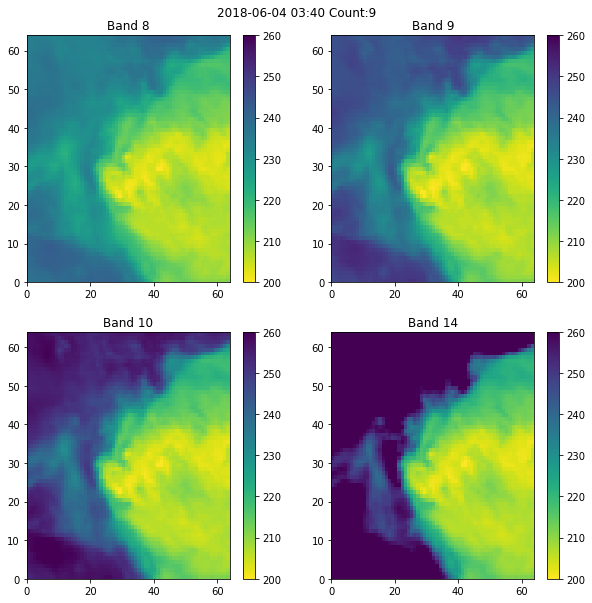

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
index = 84583
bands = [8, 9, 10, 14]
for a, ax in enumerate(axes.ravel()):
    pm = ax.pcolormesh(good_images[index, a, :, :], cmap="viridis_r", vmin=200, vmax=260)
    plt.colorbar(pm, ax=ax)
    ax.set_title(f"Band {bands[a]:d}")
fig.suptitle(good_times[index].strftime("%Y-%m-%d %H:%M Count:") + str(all_counts[index]), y=0.92)

In [18]:
all_images[index, a, :, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
all_images.shape

(84960, 64, 64, 4)

In [8]:
config = K.tf.ConfigProto(allow_soft_placement=False)
config.gpu_options.allow_growth = True
sess = K.tf.Session(config=config)
K.set_session(sess)

In [9]:
res_model = load_model("../goes16_resnet_gpus_01.h5")

In [119]:
res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          (None, 4, 64, 64)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 64, 64)   3232        scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 64, 64)   128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 32, 64, 64)   0           bn_res_00_a[0][0]                
__________________________________________________________________________________________________
res_conv_0

In [22]:
loss = (res_model.output - 1) ** 2
grad = K.gradients(loss, res_model.input)[0]
grad /= K.maximum(K.std(grad), K.epsilon())
grad_func = K.function([res_model.input, K.learning_phase()], [grad, loss])

In [23]:
input_field = np.zeros((1, 4, 64, 64), dtype=np.float32)
#input_field = scaled_images[all_counts.argmax():all_counts.argmax() + 1]
print(input_field.shape)
for i in range(20):
    grad, loss = grad_func([input_field, 0])
    print(loss)
    input_field -= 0.1 * grad

(1, 4, 64, 64)
[[0.9973945]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]


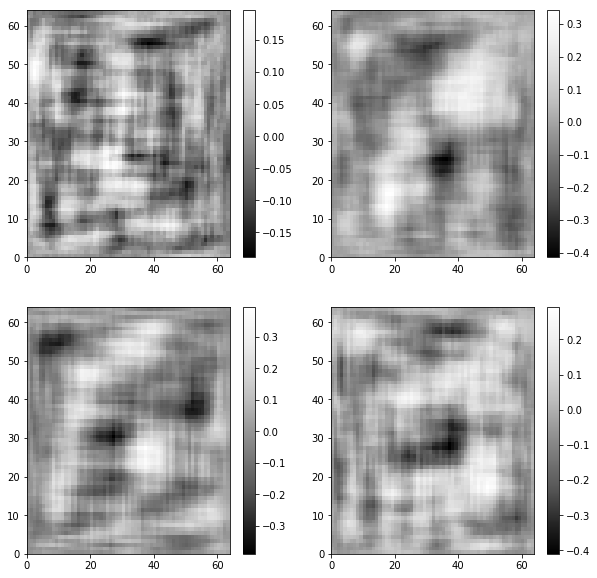

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for a, ax in enumerate(axes.ravel()):
    pc = ax.pcolormesh(input_field[0, a],cmap="Greys_r")
    plt.colorbar(pc, ax=ax)


In [12]:
input_field_data = scaled_images[84583:84584]
grad, loss = grad_func([input_field_data, 0])

In [153]:
good_counts.argsort()[::-1][:10]

array([ 7285, 79663, 84583, 60714, 81779, 69334,  8024, 83884, 79027,
       61177])

In [90]:
min_values = scaled_images[:, :, :, 0].min(axis=2).min(axis=1)

In [113]:
min_values.argmin()

10095

In [53]:
scaled_images.argmax()

1196032

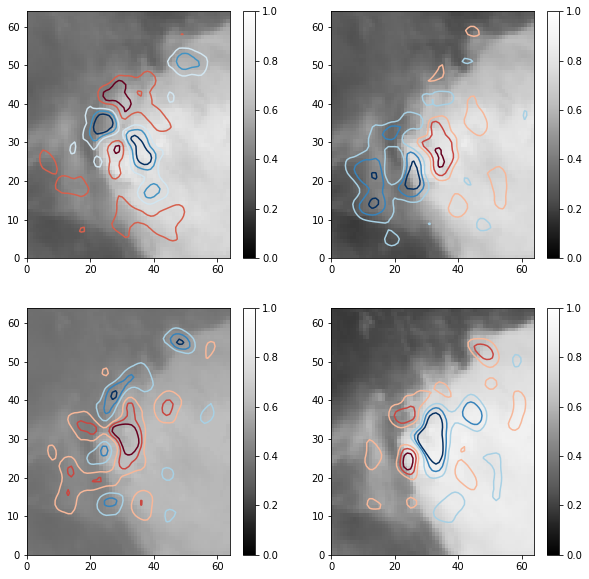

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for a, ax in enumerate(axes.ravel()):
    pc = ax.pcolormesh(input_field_data[0, a], vmin=0, vmax=1, cmap="Greys_r")
    plt.colorbar(pc, ax=ax)
    ax.contour(gaussian_filter(grad[0, a], 1) / grad[0, a].std(), [-3, -2, -1, 1, 2, 3], cmap="RdBu_r")

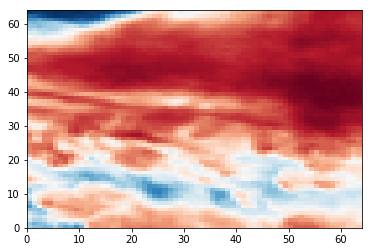

In [112]:
plt.pcolormesh(all_images[2, :, :, 0 ] - all_images[2, :, :, 2], cmap="RdBu_r")